In [27]:
# Install Folium
#pip install folium
# Install Dtale data frame visualization package
#!pip install --upgrade dtale


Carlos_Startup.ipynb
README.md
Startup.ipynb
Startup_BAH.ipynb
Startup_Neil.ipynb
Startup_Ningning.ipynb
data


In [6]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import folium
from folium.plugins import HeatMap

import dtale # data Frame visualization

import datetime   # handle date times
import re         # regular expression package

In [29]:
# Check if data has been pickled and if so load pickle
# else pickle only the attributes we are interested in, and compress
# pickle is much faster/smaller than csv
if os.path.exists('data/txDF.pkl') :
    txDF=pd.read_pickle('data/txDF.pkl',compression='gzip')
else:
    df = pd.read_csv('data/US_Accidents_Dec19.csv',encoding='utf-8')
    df.to_pickle("data/DF.pkl",compression='gzip')
    columns_of_interest=[
        'ID','Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng', 'City', 
        'County', 'State','Zipcode', 'Country','Visibility(mi)', 
        'Weather_Condition','Precipitation(in)','Sunrise_Sunset','Civil_Twilight'
    ]
    condition=df['State'] =='TX'
    txDF=df[condition][columns_of_interest] 
    txDF.to_pickle("data/txDF.pkl",compression='gzip')

In [8]:
# Number of accidents that happen at Night
txDF.groupby(['Sunrise_Sunset'])['ID'].count()

Sunrise_Sunset
Day      230645
Night     67417
Name: ID, dtype: int64

In [9]:
print(len(txDF['Precipitation(in)']))

condition = txDF['Precipitation(in)'].notnull() & txDF['Precipitation(in)'] > 0.0
precipitation= txDF[condition]

print(len(precipitation))

precipitation['Precipitation(in)'].describe()

# Over 75% of accidents happen with less than 0.1 inches of rain (if there is some precipitation)

precipitation.describe()


298062
14434


,Severity,Start_Lat,Start_Lng,Visibility(mi),Precipitation(in)
count,14434.000000,14434.000000,14434.000000,14385.000000,14434.000000
mean,2.327421,30.913708,-96.832317,5.874516,0.099047
std,0.493469,1.387663,1.464003,3.285179,0.184035
min,1.000000,26.081497,-106.492615,0.000000,0.010000
25%,2.000000,29.769635,-97.712143,3.000000,0.010000
50%,2.000000,30.260734,-96.823794,6.000000,0.040000
75%,3.000000,32.720496,-95.500839,10.000000,0.100000
max,4.000000,35.816620,-93.781326,10.000000,2.940000


In [10]:
txDF['Weather_Condition'].value_counts()

Clear                                  76753
Mostly Cloudy                          47948
Overcast                               45135
Partly Cloudy                          37059
Scattered Clouds                       25356
                                       ...  
Light Snow / Windy                         2
Rain Shower                                2
Thunderstorms and Snow                     1
Heavy Thunderstorms with Small Hail        1
Thunder and Hail / Windy                   1
Name: Weather_Condition, Length: 65, dtype: int64

In [11]:
txDF['Visibility(mi)'].value_counts()

10.00     232214
9.00       10617
7.00        8271
8.00        6966
5.00        5329
6.00        4797
4.00        4046
3.00        3943
13.00       3760
2.00        2511
2.50        1629
1.00        1444
0.20        1379
0.50         912
1.50         855
1.80         697
0.80         627
1.20         486
0.10         180
11.00        146
12.00        143
20.00        122
0.75          97
0.25          84
0.00          79
0.40          19
2.80          14
0.70          12
0.12          11
1.90           8
15.00          7
1.60           5
5.50           5
0.06           5
2.20           4
10.50          3
111.00         3
0.60           3
3.50           3
1.10           2
0.90           2
0.63           2
46.00          1
1.40           1
Name: Visibility(mi), dtype: int64

# Date Attributes

Separate the *start_time* attribute into it several date components


In [12]:
# code fron fast ai
# Date Feature Engineering
# will split data colum in to corresponding 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear'
def add_datepart(df, fldname, drop=True,time=False):
    fld = df[fldname]
    attributes = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attributes = attributes + ['Hour', 'Minute', 'Second']
    #, 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in attributes:
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)


In [30]:
add_datepart(txDF,'Start_Time',False,True )
txDF.columns

26

In [14]:
txDF.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,...,Start_TimeYear,Start_TimeMonth,Start_TimeWeek,Start_TimeDay,Start_TimeDayofweek,Start_TimeDayofyear,Start_TimeHour,Start_TimeMinute,Start_TimeSecond,Start_TimeElapsed
261007,A-261009,2,2016-11-30 16:03:54,2016-11-30 17:20:00,30.336502,-97.755646,Austin,Travis,TX,78731,...,2016,11,48,30,2,335,16,3,54,1480521834
261008,A-261010,2,2016-11-30 16:32:18,2016-11-30 17:47:02,30.328165,-97.694305,Austin,Travis,TX,78752-2826,...,2016,11,48,30,2,335,16,32,18,1480523538
261009,A-261011,2,2016-11-30 16:31:45,2016-11-30 17:46:34,30.326077,-97.692307,Austin,Travis,TX,78752,...,2016,11,48,30,2,335,16,31,45,1480523505
261010,A-261012,2,2016-11-30 16:06:49,2016-11-30 17:27:00,32.856014,-97.513084,Fort Worth,Tarrant,TX,76135,...,2016,11,48,30,2,335,16,6,49,1480522009
261011,A-261013,3,2016-11-30 16:35:01,2016-11-30 17:49:39,32.797668,-97.212090,Fort Worth,Tarrant,TX,76118,...,2016,11,48,30,2,335,16,35,1,1480523701


In [15]:
def dow(df):
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    return days[df]
    

txDF['Start_TimeDayofweek'] =txDF['Start_TimeDayofweek'].apply(dow)


In [16]:
txDF['Start_TimeDayofweek'].head()

261007    Wednesday
261008    Wednesday
261009    Wednesday
261010    Wednesday
261011    Wednesday
Name: Start_TimeDayofweek, dtype: object

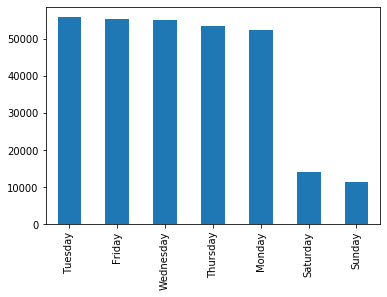

In [17]:
txDF['Start_TimeDayofweek'].value_counts().plot(kind='bar')

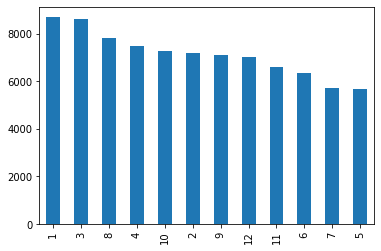

In [18]:
condition = txDF['Start_TimeYear'] == 2017

txDF[condition]['Start_TimeMonth'].value_counts().plot(kind='bar')


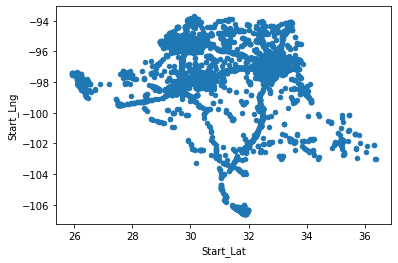

In [19]:
txDF.plot.scatter(x='Start_Lat',y='Start_Lng')

In [20]:
def plot_map1(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
#                           tiles = "Stamen Toner",
                           tiles = "OpenStreetMap",                              
                           zoom_start = 10)
    if city != None:
        data_heatmap = df[df["City"] == city]
    else:
        data_heatmap = df.copy()
    data_heatmap = data_heatmap[['Start_Lat','Start_Lng']]
    data_heatmap = [[row['Start_Lat'],row['Start_Lng']] for index, row in data_heatmap.iterrows()]
    HeatMap(data_heatmap, radius=10).add_to(accident_map)
    return accident_map

In [21]:

condition = txDF['Start_TimeYear'] == 2017

plot_map1(txDF[condition],[30.2672,-97.7431])


# Accidents in one Day



In [22]:
condition = (txDF['Start_TimeYear'] == 2017) & (txDF['City'] == 'Austin')
vc = txDF[condition]['Start_TimeDayofyear'].value_counts()
vc

340    120
13     117
90     101
111     94
100     93
      ... 
336      1
190      1
260      1
280      1
359      1
Name: Start_TimeDayofyear, Length: 332, dtype: int64

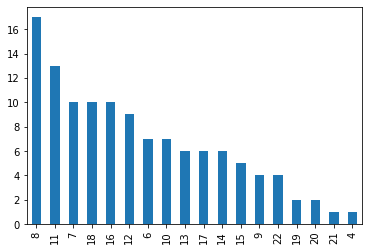

In [23]:
condition = (txDF['Start_TimeYear'] == 2017) & (txDF['City'] == 'Austin')  & (txDF['Start_TimeDayofyear']==340)
txDF[condition]['Start_TimeHour'].value_counts().plot(kind='bar')

In [24]:
timeBins = [0,5,9,13,16,19,24]
groupNames = ['<5','6-9','10-13','14-16','16-19','19-24']
txDF['HourGroup']=pd.cut(txDF['Start_TimeHour'],timeBins, labels=groupNames)
txDF['HourGroup'].head()

261007    14-16
261008    14-16
261009    14-16
261010    14-16
261011    14-16
Name: HourGroup, dtype: category
Categories (6, object): [<5 < 6-9 < 10-13 < 14-16 < 16-19 < 19-24]

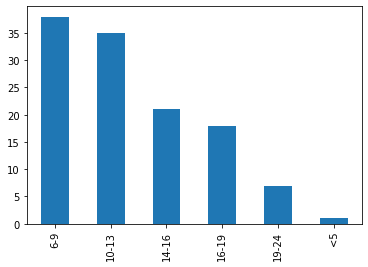

In [25]:
condition = (txDF['Start_TimeYear'] == 2017) & (txDF['City'] == 'Austin')  & (txDF['Start_TimeDayofyear']==340)
txDF[condition]['HourGroup'].value_counts().plot(kind='bar')

In [26]:
condition = (txDF['Start_TimeYear'] == 2017) & (txDF['City'] == 'Austin')  & (txDF['Start_TimeDayofyear']==340)
onedf=txDF[condition].sort_values('Start_TimeHour')
import dtale
d= dtale.show(onedf,ignore_duplicate=True)
d